In [2]:
import numpy as np
import astropy as ap
import scipy as sp
from scipy import stats
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv
import pickle

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

In [4]:
# Constants and other setup variables. Spherical points should be (theta, phi)
# low_energy_resolution = .5*np.pi/180     (NO longer useful)
# high_energy_resolution = .3*np.pi/180    (NO longer useful)
lisa_resolution = 1*np.pi/180
NSIDE = 128
Npix = hp.nside2npix(NSIDE)

In [5]:
# Old school/naive way of making events
# low_energy_map = np.zeros(Npix) + low_energy_resolution + np.random.rand(Npix)
# high_energy_map = np.zeros(Npix) + high_energy_resolution + np.random.rand(Npix)

In [6]:
# Monte Carlo values
# time_vals = [10, 1000, 10000, 100000, 1000000]
# emri_array = [1, 100, 1000, 4000]
# mbh_array = [1,2,3]
# position_array = [1,2,3,4,5]

In [7]:
# Sample MC values
# Add values in each array depending on what parameter space you want to explore
time_vals = [500000]
emri_array = [5000]
mbh_array = [50]
position_array = [1]

In [8]:
# Rate constants Event rates are events/year.

# time_diff = 100000
low_energy_rate = 50
high_energy_rate = 70
time_diff = 500 #usually 500
mbh_rate = 3
emri_rate = 500 #usually 500
position_factor = 1
msec_in_year = 60*60*24*365

In [9]:
def Ang2Vec(theta,phi):
    """ Takes spherical angles (theta [inclination], phi [azimuth]) and returns a point on the surface a sphere """
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

In [10]:
def add_time(count):
    """ Uniform distribution of events throughout a year """
    time = np.random.randint(msec_in_year, size=count)
    return time

In [11]:
def random_point(count):
    """ Get random points on a sphere (uniform distribution)"""
    phi = np.random.random(count)*2*np.pi
    costheta = np.random.random(count)*2 - 1
    theta = np.arccos(costheta)
    return np.array([theta, phi]).T

In [12]:
def plot_gaussian_event(etheta, ephi, sigma, amp):
    """ Gaussian smoothing of events """
    theta,phi=hp.pix2ang(NSIDE,np.arange(Npix))
    return amp*np.exp(-((phi - ephi)**2+(theta - etheta)**2)/(2*sigma**2))

In [13]:
def healpix_smooth(etheta, ephi, sig, amp):
    """ HEALpix method of smoothing """
    pind = hp.ang2pix(NSIDE, etheta, ephi)
    temp = np.zeros(Npix)
    temp[pind] = amp
    return hp.smoothing(temp, sigma=sig)

In [14]:
def lisa_noise(count):
    """ Noise on LISA observations """ 
#     return np.random.normal(size=count)*np.array(lisa_resolution)
    return np.ones(count)*lisa_resolution

In [15]:
def hen_noise_fn(theta, const):
    """ Fitted function to get noise on event based on theta """ 
    costhet = np.cos(theta)
    return (const*costhet**2 +.2)*np.pi/180

In [16]:
def hen_noise(positions, category):
    """ Noise for a list of HEN events 
    category = 0 --> low energy, 1 --> high energy"""
    thets = positions[:,0]
    count = len(positions)
    if category == 0:
        noise_means = hen_noise_fn(thets, .9)
    else:
        noise_means = hen_noise_fn(thets, .4)
    return np.ones(count)*noise_means

In [17]:

def general_noise(count, hen, category, points=0):
    """ Wrapper function to get noise on events. 
    hen=True --> HEN events, hen=False --> GW events
    hen=True: category = 0 --> low energy, 1 --> high energy
    hen=False, category = 0 --> EMRI, 1 --> MBH  """
    if hen:
        noise_val = hen_noise(points, category)
    else:
        noise_val = lisa_noise(count)
    return noise_val

In [ ]:
def load_simulation_data(filename):
    """ Load simulated HEN events """ 
    gen2bundle = pickle.load(open(filename, 'rb'), encoding='bytes')
    events_bundle = []
    for gen2data in gen2bundle:
        gen2energy = gen2data[0]
        gen2noises = gen2data[1]
        gen2thet = gen2data[2]
        gen2phi = gen2data[3]
        gen2time = gen2data[4]
        gen2events = [np.array([gen2thet, gen2phi]).T, gen2noises, gen2time, gen2energy]
        events_bundle.append(gen2events)
    
    return events_bundle

In [104]:
def general_event(poisson_lambda, hen, category, filename="sample_data_1.p"):
    """ Wrapper function for generating events."""
    if hen:
        events = load_simulation_data("sample_data_1.p"")
    else:
        # LISA events are generated naively here
        k = np.random.poisson(lam=poisson_lambda)
        points = random_point(k)
        noise = general_noise(k, hen, category, points).T
        time = add_time(k)
        events = [points, noise, time]
    return [points, noise, time]

In [19]:
def make_hp_map(points, noise):
    """ Create healpix map of events with error smoothing """
    temp_map = np.zeros(Npix)
    for i,v in enumerate(points):
        temp_map += healpix_smooth(*v, noise[i], 1)
    return temp_map

In [20]:
def position_coincident(p1, p2, n1, n2):
    """ Check if two positions and associated noises are coincident """
    pvec1 = Ang2Vec(*p1)
    pvec2 = Ang2Vec(*p2)
    dist = np.linalg.norm(pvec1 - pvec2)
    if dist < (n1 + n2)*position_factor:
        return True
    else:
        return False

In [21]:
def time_coincident(t1, t2):
    """ Fast way to check if there are time coincident events """
    d = {}
    keys, vals = np.where(np.abs(np.subtract.outer(t1, t2)) <= time_diff)
#     for i in range(len(keys)):
#         d[keys[i]] = vals[i]
    return keys, vals

In [22]:
def overlap(e1, n1, t1, e2, n2, t2, number=True):
    """ Given events, noises, and times, calculate the number of overlaps """
    ks, vs = time_coincident(t1, t2)
    overlap_counter = 0
    pairs_overlap = []
    noise_overlap = []
    for i,v in enumerate(ks):
        pos_1 = e1[v]
        noise_1 = n1[v]
        pos_2 = e2[vs[i]]
        noise_2 = n2[vs[i]]
        l = position_coincident(pos_1, pos_2, noise_1, noise_2)
        if l:
            if not number:
                pairs_overlap.append([pos_1,pos_2])
                noise_overlap.append([noise_1, noise_2])
            overlap_counter += 1
    
    return overlap_counter, pairs_overlap, noise_overlap

In [23]:
def napkin_check(n=1000):
    """ Convenience function to check our naive calculation """
    lval = []
    clean_n = int(n)
    for i in tqdm(range(clean_n)):
        high = general_event(high_energy_rate, True, 1)
        emri = general_event(emri_rate, False, 0)
        h_e, _, _ = overlap(*high, *emri, True)
        lval.append(h_e)
    return lval

In [24]:
def monte_carlo_run(number):
    """ Single Monte Carlo run that generates all events and calculates coincident pairs """ 
    low = general_event(low_energy_rate, True, 0)
    high = general_event(high_energy_rate, True, 1)
    emri = general_event(emri_rate, False, 0)
    mbh = general_event(mbh_rate, False, 1)
    l_e, le_p, le_n = overlap(*low, *emri, number)
    l_m, lm_p, lm_n = overlap(*low, *mbh, number)
    h_e, he_p, he_n = overlap(*high, *emri, number)
    h_m, hm_p, hm_n = overlap(*high, *mbh, number)
    
    return np.array([l_e, l_m, h_e, h_m]), np.array([le_p,lm_p,he_p,hm_p]), np.array([le_n, lm_n, he_n, hm_n])

In [24]:
def mc_big_hammer(number, n=100, make_arrays=False, make_plots=False):
    """ Overkill but can run generate all data and extract overlaps
    for a variety of settings. Almost certainly better to use monte_carlo_run
    with specific settings. """
    global time_diff
    global emri_rate
    global mbh_rate
    global position_factor
    with open('output/monte_run.csv', 'w') as csvfile:
        a = csv.writer(csvfile)
        header = ['n', 'time_diff', 'position_factor', 'emri', 'mbh', 'total_coincident']
        a.writerow(header)
    with open('output/total_run.csv', 'w') as csvfile:
        b = csv.writer(csvfile)
        header = ['n', 'time_diff', 'position_factor', 'emri', 'mbh', 'total_coincident']
        b.writerow(header)
    for i in time_vals:
        time_diff = i
        for j in emri_array:
            emri_rate = j
            for k in mbh_array:
                mbh_rate = k
                for l in position_array:
                    lval=[]
                    position_factor = l
                    for m in tqdm.notebook.tqdm(range(n)):
                        monte_data,points,noise = monte_carlo_run(number)
                        total = np.sum(monte_data)
                        lval.append(total)
                        monte_name = 'monte_big_time%i_emri%i_mbh%i_pos%i_%i_' % (i, j, k, l, m)
                        if make_arrays:
                            np.save('output/' + monte_name, monte_data)
                        if total > 0 and make_plots:
                            big_map = np.zeros(Npix)
                            for map_index in range(len(points)):
                                temp_map = np.zeros(Npix)
                                if monte_data[map_index] == 0:
                                    continue
                                noises = []
                                pointses = []
                                for pair_ind in range(len(noise[map_index])):
                                    noises += noise[map_index][pair_ind]
                                    pointses += points[map_index][pair_ind]
                                temp_map += make_hp_map(pointses, noises)
                                big_map += temp_map
                                
                                np.save('maps/'+monte_name+'map_'+str(map_index),temp_map)
                                hp.mollview(temp_map)
                                plt.savefig('maps/'+monte_name+'mollview_'+str(map_index))
                                plt.close()
                            hp.mollview(big_map)
                            plt.savefig('maps/'+monte_name+'mollview')
                            plt.close()
                        with open('output/monte_run.csv', 'a') as csvfile:
                            c = csv.writer(csvfile)
                            data = [m,i,l,j,k,total]
                            c.writerow(data)
                    run_total = np.sum(lval)
                    with open('output/total_run.csv', 'a') as csvfile:
                        d = csv.writer(csvfile)
                        data = [n,i,l,j,k,run_total]
                        d.writerow(data)
                    if make_arrays:
                        array_name = 'lval_big_time%i_emri%i_mbh%i_pos%i_%i_' % (i, j, k, l, n)
                        np.save('output/' + array_name, lval)
                    if make_plots:
                        plt.hist(lval);
                        plt.savefig('images/' + array_name)
                        plt.close()

In [25]:
def mc(number, n=100):
    """ Monte carlo function. 100 (n) runs of monte_carlo_run """
    lval = []
    pval = []
    nval = []
    for i in tqdm(range(n)):
        k, p, n = monte_carlo_run(number)
        lval.append(k)
        if p.size > 0:
            pval.append(p)
        if n.size > 0:
            nval.append(n)
    return lval, pval, nval

In [26]:
def get_data(arry):
    """ Reformat data """
    clean_a = []
    for ps in arry:
        for p in ps:
            if p:
                clean_a.append(p[0][0])
                clean_a.append(p[0][1])
    return clean_a

In [27]:
def carlo_plots(positions, noises):
    """ Create plots of events from MC """
    clean_p = get_data(positions)
    newp = np.array(clean_p)
    clean_n = get_data(noises)
    clean_n = np.array(clean_n)
    newn = clean_n.flatten()

    hp_plot = make_hp_map(newp, newn)
    return hp_plot
        

In [28]:
# Easy access to redefine the parameters
low_energy_rate = 50
high_energy_rate = 70
time_diff = 1e5 #usually 500
mbh_rate = 30
emri_rate = 70 #usually 500
position_factor = 1

In [29]:
timelog = int(np.log10(time_diff))
gwe = int(np.log10(mbh_rate + emri_rate))

In [30]:
# Single run to check if things are all ok
monte_carlo_run(False)

(array([0, 0, 0, 0]),
 array([], shape=(4, 0), dtype=float64),
 array([], shape=(4, 0), dtype=float64))

In [32]:
# 1000 runs of MC
n = int(1e3)
m, pos, ns = np.array(mc(False, n))

In [33]:
# Total number of coincidences 
np.sum(m)

19

Text(0.5, 1.0, 'Time delta 10^5 with GWE 10^2')

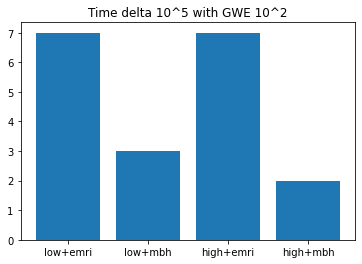

In [34]:
# Plot types of coincidence
plt.bar(["low+emri", "low+mbh", "high+emri", "high+mbh"], np.sum(m, axis=0))
plt.title("Time delta 10^%i with GWE 10^%i" % (timelog, gwe))

In [632]:
high = general_event(70, True, 0)
emri = general_event(500, False, 0)
h_e, he_p, he_n = overlap(*high, *emri)

In [35]:
nap_check = napkin_check(1e3)

In [36]:
np.mean(nap_check)

0.003